# Predicting painting authors

In this notebook, I will build a model to predict authors of paintings. I will use the [dataset](https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time) from Kaggle that has 8,000+ paintings by 50 most famous artists to train the model.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
tf.get_logger().setLevel('ERROR')

Let's start with exploring the information about the paintings in the dataset. Luckily, there is a csv file summarizing information about all paintings in the dataset and their authors. I will read it as a pandas dataframe.

In [ ]:
artists = pd.read_csv(r'data\artists.csv').drop(columns=['id', 'bio', 'wikipedia'])

#sorting the dataframe by the number of paintings in the dataset
artists.sort_values('paintings', ascending=False).reset_index(drop=True)

Vincent van Gogh has the most paintings in the dataset, followed by Edgar Degas and Pablo Picasso. The difference between artists withe the most and the least paintings is large, meaning that the dataset is imbalanced. I'll deal with it later.

Each artist in the dataset is associated with one or more genres. Let's have a look at the distributrion of artists' genres.

In [ ]:
#getting all genres from the genre column
genre_count = artists.genre.str.get_dummies(sep=',').sum().sort_values()

#plotting the number of genres in the dataset
genre_count.plot.barh()
plt.show()

Impressionism and Post-Impressionism are the most popular genres, if we only count individual artists. There are also plenty of artists associated with different periods and types of Renaissance art.

The paintings is stored on my local machine. Below, I display some of the paintings, selected randomly. The code used here is adapted from this Stackoverflow [answer](https://stackoverflow.com/a/60443998).

In [ ]:
#getting the list of all filepaths
train_folder = 'data\images'
images = {}
for folder in os.listdir(train_folder):
    for image in os.listdir(train_folder + '/' + folder):
        filename = os.path.join(train_folder, folder, image)
        author = folder.replace('_', ' ')
        images[filename] = author
        
plt.figure(1, figsize=(12, 8))

#displaying nine randimly selected images
n = 0
for i in range(9):
    n += 1
    random_img = random.choice(list(images.keys()))
    imgs = plt.imread(random_img)
    plt.subplot(3, 3, n)
    plt.axis('off')
    plt.imshow(imgs)
    plt.title(images[random_img])

plt.show()

In [3]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data\images',
    validation_split=0.2,
    subset='training',
    seed=17,
    image_size=image_size,
    batch_size=batch_size,
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data\images',
    validation_split=0.2,
    subset='validation',
    seed=17,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8446 files belonging to 50 classes.
Using 6757 files for training.
Found 8446 files belonging to 50 classes.
Using 1689 files for validation.


In [10]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.GaussianNoise(20),
    # tf.keras.layers.RandomBrightness(0.2),
    # tf.keras.layers.RandomContrast(0.2)
])

In [47]:
def visualize(original, augmented):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original[0].numpy().astype("int32"))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented[0].numpy().astype("int32"))
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


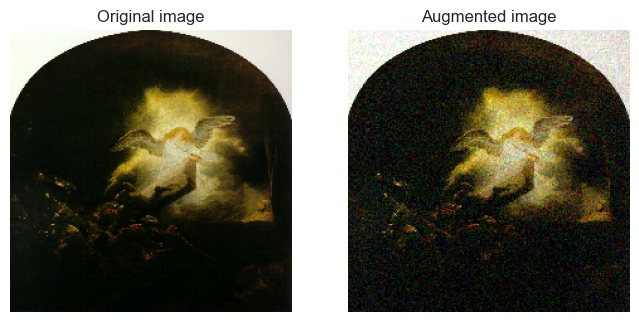

In [60]:
image, label = next(iter(train_ds))
flipped = tf.keras.layers.GaussianNoise(20)(
            tf.expand_dims(image[0], 0), training=True
            )
visualize(image, flipped)

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50)
])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
#getting predicted probabilities
y_pred_proba = model.predict(valid_ds)

#getting predicted classes - https://github.com/keras-team/keras/issues/5961
y_pred = y_pred_proba.argmax(axis=-1)

#getting actual classes - https://stackoverflow.com/a/62823218
y = np.concatenate([y for x, y in valid_ds], axis=0)

artists_alphabetic = artists.sort_values('name').reset_index(drop=True)
artists_dict = dict(zip(artists_alphabetic.index, artists_alphabetic.name))

pred_artists = [artists_dict[k] for k in y_pred]
actual_artists = [artists_dict[k] for k in y]
results_df = pd.DataFrame({'predicted': pred_artists, 'actual': actual_artists})
results_df['result'] = results_df.predicted == results_df.actual

In [ ]:
correct_by_artist = results_df.groupby('actual')['result'].mean()
correct_by_artist = pd.DataFrame({'name': correct_by_artist.index, 'share_correct': correct_by_artist.values})

artist_paintings_dict = dict(zip(artists.name, artists.paintings))

correct_by_artist['total_paintings'] = correct_by_artist.name.map(artist_paintings_dict)
correct_by_artist.sort_values('share_correct', ascending=False)

sns.regplot(y=correct_by_artist['share_correct'], x=correct_by_artist['total_paintings'], ci=None)

In [4]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data\images',
    validation_split=0.2,
    subset='training',
    seed=17,
    image_size=image_size,
    batch_size=batch_size,
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data\images',
    validation_split=0.2,
    subset='validation',
    seed=17,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8446 files belonging to 50 classes.
Using 6757 files for training.
Found 8446 files belonging to 50 classes.
Using 1689 files for validation.


In [14]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layers in base_model.layers[:143]:
    layers.trainable = False

resizing_layer = tf.keras.layers.Resizing(224, 224)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(50, activation='softmax')

model = tf.keras.Sequential([
    resizing_layer,
    # data_augmentation,
    base_model,
    global_average_layer,
    dropout_layer,
    prediction_layer
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=15
)

Epoch 1/15
212/212 [==============================] - 705s 3s/step - loss: 2.1253 - accuracy: 0.4706 - val_loss: 1.7217 - val_accuracy: 0.5938
Epoch 2/15
212/212 [==============================] - 605s 3s/step - loss: 0.6266 - accuracy: 0.8427 - val_loss: 1.2708 - val_accuracy: 0.6631
Epoch 3/15
212/212 [==============================] - 601s 3s/step - loss: 0.1607 - accuracy: 0.9728 - val_loss: 1.1583 - val_accuracy: 0.6815
Epoch 4/15
212/212 [==============================] - 600s 3s/step - loss: 0.0496 - accuracy: 0.9917 - val_loss: 1.2014 - val_accuracy: 0.7057
Epoch 5/15
212/212 [==============================] - 609s 3s/step - loss: 0.0266 - accuracy: 0.9963 - val_loss: 1.5404 - val_accuracy: 0.6856
Epoch 6/15
212/212 [==============================] - 650s 3s/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 1.7448 - val_accuracy: 0.6619
Epoch 7/15
212/212 [==============================] - 627s 3s/step - loss: 0.0155 - accuracy: 0.9970 - val_loss: 1.3770 - val_accuracy: 0.6933

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, 21)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
image_size= (224, 224)
batch_size = 32

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data\images',
    seed=17,
    image_size=image_size,
    batch_size=batch_size,
)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(50, activation='softmax')

model = tf.keras.Sequential([
    data_augmentation
    base_model,
    global_average_layer,
    dropout_layer,
    prediction_layer
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    full_ds,
    epochs=10
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, 11)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
model.save('saved_model/my_model')

In [ ]:
image = tf.keras.utils.load_img(r'test_data\vangoghmuseum-s0005V1962-800.jpg')
input_arr = tf.keras.utils.img_to_array(image)
input = tf.image.resize(input_arr, [224, 224])
input = tf.keras.applications.resnet50.preprocess_input(input)
input = np.array([input])
predictions = model.predict(input)
predictions